In [10]:
%cd /data/vision/torralba/graphphys/transformer_experiments/transformer/6.8200_final_project/

/data/vision/torralba/graphphys/transformer_experiments/transformer/6.8200_final_project


In [11]:
from PushTImageEnv import PushTImageEnv
from data_vision import PushTImageDataset, unnormalize_data, normalize_data
import torch as t
import torch
from torch import nn
import torchvision
import numpy as np
from conditional_unet1d import ConditionalUnet1D
from transformer_for_diffusion import TransformerForDiffusion
from diffusers.training_utils import EMAModel
from diffusers import DDPMScheduler, DDIMScheduler
from diffusers.optimization import get_scheduler
from tqdm.notebook import tqdm
import collections
import matplotlib.pyplot as plt

import pickle

In [3]:
values = [1, 2, 3, 4, 5, 6, 8]
paths = [f"results_tuning/vision_results_obs_horizon_{val}_tuning.pkl" for val in values]

losses = []
models = []
for path in tqdm(paths):
    with open(path, "rb") as file:
        losses1 = pickle.load(file)
        losses.append(losses1[0])
        models.append(losses1[1])

  0%|          | 0/7 [00:00<?, ?it/s]

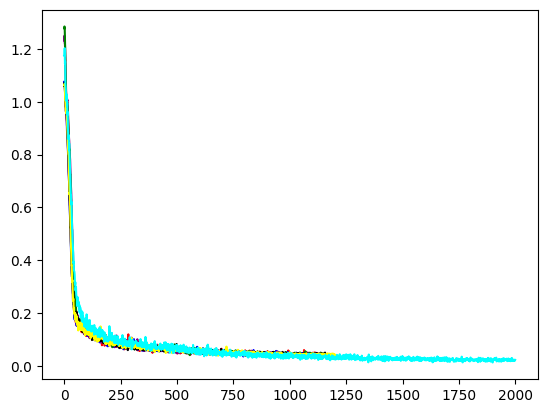

In [7]:
import matplotlib.pyplot as plt

colors = ["red", "blue", "purple", "green", "black", "yellow", "cyan"]

for i in range(len(losses)):
    plt.plot(losses[i], color=colors[i])

In [3]:
diffusion_timesteps = 100

noise_scheduler = DDPMScheduler(
    num_train_timesteps=diffusion_timesteps,
    beta_schedule='squaredcos_cap_v2',
    clip_sample=True,
    prediction_type='epsilon'
)

dataset_path = "pusht_cchi_v7_replay.zarr"

# create dataset from file
dataset = PushTImageDataset(
    dataset_path=dataset_path,
    pred_horizon=1,
    obs_horizon=1,
    action_horizon=1
)

stats = dataset.stats

env = PushTImageEnv(reset_to_state=np.array([150, 350, 350, 150, np.pi/4]))
# use a seed >200 to avoid initial states seen in the training dataset
env.seed(300)

In [7]:
def run_inference(ema, env=env, obs_horizon=2, max_steps=500, device="cuda", stop_reward=0.9, action_horizon=8, pred_horizon=16, action_dim=2):
# # limit enviornment interaction to 200 steps before termination
# max_steps = 500
# env = PushTImageEnv()
# # use a seed >200 to avoid initial states seen in the training dataset
# env.seed(100000)

    ema.averaged_model[0].to(device)
    ema.averaged_model[1].to(device)

    # get first observation
    obs = env.reset()

    # keep a queue of last 2 steps of observations
    obs_deque = collections.deque(
        [obs] * obs_horizon, maxlen=obs_horizon)
    # save visualization and rewards
    imgs = [env.render(mode='rgb_array')]
    rewards = list()
    done = False
    step_idx = 0
    obs_list = [obs]

    with tqdm(total=max_steps, desc="Eval PushTImageEnv") as pbar:
        while not done:
            B = 1
            # stack the last obs_horizon number of observations
            images = np.stack([x['image'] for x in obs_deque])
            agent_poses = np.stack([x['agent_pos'] for x in obs_deque])

            # normalize observation
            nagent_poses = normalize_data(agent_poses, stats=stats['agent_pos'])
            # images are already normalized to [0,1]
            nimages = images

            # device transfer
            nimages = torch.from_numpy(nimages).to(device, dtype=torch.float32)
            # (2,3,96,96)
            nagent_poses = torch.from_numpy(nagent_poses).to(device, dtype=torch.float32)
            # (2,2)

            # infer action
            with torch.no_grad():
                # get image features
                image_features = ema.averaged_model[0](nimages)
                # (2,512)

                # concat with low-dim observations
                obs_features = torch.cat([image_features, nagent_poses], dim=-1)

                # reshape observation to (B,obs_horizon*obs_dim)
                obs_cond = obs_features.unsqueeze(0).flatten(start_dim=1)

                # initialize action from Guassian noise
                noisy_action = torch.randn(
                    (B, pred_horizon, action_dim), device=device)
                naction = noisy_action

                # init scheduler
                noise_scheduler.set_timesteps(diffusion_timesteps)

                for k in noise_scheduler.timesteps:
                    # predict noise
                    noise_pred = ema.averaged_model[1](
                        sample=naction,
                        timestep=k,
                        global_cond=obs_cond
                    )

                    # inverse diffusion step (remove noise)
                    naction = noise_scheduler.step(
                        model_output=noise_pred,
                        timestep=k,
                        sample=naction
                    ).prev_sample

            # unnormalize action
            naction = naction.detach().to('cpu').numpy()
            # (B, pred_horizon, action_dim)
            naction = naction[0]
            action_pred = unnormalize_data(naction, stats=stats['action'])

            # only take action_horizon number of actions
            start = obs_horizon - 1
            end = start + action_horizon
            action = action_pred[start:end,:]
            # (action_horizon, action_dim)

            # execute action_horizon number of steps
            # without replanning
            for i in range(len(action)):
                # stepping env
                obs, reward, done, info = env.step(action[i])
                # save observations
                obs_deque.append(obs)
                obs_list.append(obs)
                # and reward/vis
                rewards.append(reward)
                imgs.append(env.render(mode='rgb_array'))

                # update progress bar
                step_idx += 1
                pbar.update(1)
                pbar.set_postfix(reward=reward)
                if step_idx > max_steps or reward >= stop_reward:
                    done = True
                if done:
                    break
    return rewards, imgs, obs_list

In [5]:
results_rewards = []
for j in tqdm(range(1, len(losses))):
    obs_horizon = values[j]
    all_rewards = []
    all_imgs = []
    all_obs = []
    for i in tqdm(range(10)):
        rewards, imgs, obs_list = run_inference(models[j], obs_horizon=obs_horizon)
        all_rewards.append(rewards)
        all_imgs.append(imgs)
        all_obs.append(obs_list)
        
    results_rewards.append(all_rewards)

NameError: name 'losses' is not defined